This notebook reuses code from https://www.kaggle.com/code/agggshambhavi/pytorch-brain-mri-binary-segmentation

# Imports

In [1]:
import os

import numpy as np
import pandas as pd

from PIL import Image
import cv2

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining parameters

In [2]:
data_dir = "../shared_fs/kaggle_3m/" # change the path accordingly

train_fraction = 0.8
validation_fraction = 0.2
batch_size = 16

input_dim = 256
input_ch = 3
output_dim = 256
output_ch = 1

learning_rate = 0.01
epochs = 25
seed = 1

# Reading images path

In [3]:
dirs, images, masks = [], [], []

for root, folders, files in  os.walk(data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_14.tif,TCGA_CS_6186_20000601_14_mask.tif
1,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_5.tif,TCGA_CS_6186_20000601_5_mask.tif
2,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_23.tif,TCGA_CS_6186_20000601_23_mask.tif
3,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_18.tif,TCGA_CS_6186_20000601_18_mask.tif
4,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_9.tif,TCGA_CS_6186_20000601_9_mask.tif


In [4]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [5]:
PathDF.head()

,directory,images,masks,diagnosis
0,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_14.tif,TCGA_CS_6186_20000601_14_mask.tif,0.0
1,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_5.tif,TCGA_CS_6186_20000601_5_mask.tif,0.0
2,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_23.tif,TCGA_CS_6186_20000601_23_mask.tif,0.0
3,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_18.tif,TCGA_CS_6186_20000601_18_mask.tif,1.0
4,TCGA_CS_6186_20000601,TCGA_CS_6186_20000601_9.tif,TCGA_CS_6186_20000601_9_mask.tif,0.0


In [6]:
train_df, valid_df = train_test_split(PathDF, random_state=seed,
                                 test_size = validation_fraction)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])

Train: 3143
Valid: 786


In [7]:
train_df

,directory,images,masks,diagnosis
1544,TCGA_HT_7692_19960724,TCGA_HT_7692_19960724_20.tif,TCGA_HT_7692_19960724_20_mask.tif,1.0
2433,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_12.tif,TCGA_CS_6667_20011105_12_mask.tif,1.0
3473,TCGA_DU_6408_19860521,TCGA_DU_6408_19860521_5.tif,TCGA_DU_6408_19860521_5_mask.tif,0.0
3710,TCGA_FG_5962_20000626,TCGA_FG_5962_20000626_33.tif,TCGA_FG_5962_20000626_33_mask.tif,1.0
195,TCGA_DU_5849_19950405,TCGA_DU_5849_19950405_22.tif,TCGA_DU_5849_19950405_22_mask.tif,1.0
...,...,...,...,...
905,TCGA_DU_8163_19961119,TCGA_DU_8163_19961119_9.tif,TCGA_DU_8163_19961119_9_mask.tif,0.0
3839,TCGA_FG_7637_20000922,TCGA_FG_7637_20000922_10.tif,TCGA_FG_7637_20000922_10_mask.tif,0.0
1096,TCGA_DU_6400_19830518,TCGA_DU_6400_19830518_28.tif,TCGA_DU_6400_19830518_28_mask.tif,1.0
235,TCGA_EZ_7264_20010816,TCGA_EZ_7264_20010816_23.tif,TCGA_EZ_7264_20010816_23_mask.tif,0.0


# Creating Torch Datasets and DataLoaders

In [8]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform
        
    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        
        base_path = os.path.join(data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        sample = (image, mask)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample            

Preprocessing function to apply to images

In [9]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

Data transformation techniques for data augmentation

In [10]:
class PairedRandomHorizontalFlip():
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        img, mask = sample
        if np.random.random() < self.p:
            img, mask = TF.hflip(img), TF.hflip(mask)
            
        return img, mask

In [11]:
class PairedRandomAffine():
    
    def __init__(self, degrees= None, translate=None, scale_ranges=None,
                shears=None):
        self.params = {
            'degree': degrees,
            'translate': translate,
            'scale_ranges':scale_ranges,
            'shears':shears
        }
    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            self.params['degree'], self.params['translate'],
            self.params['scale_ranges'], self.params['shears'],
            (w,h)
        )
        
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        
        return img, mask

In [12]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap="gray")
    if title:
        fig.suptitle(title)
    plt.show()

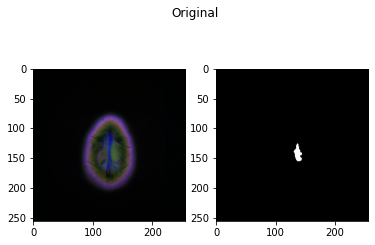

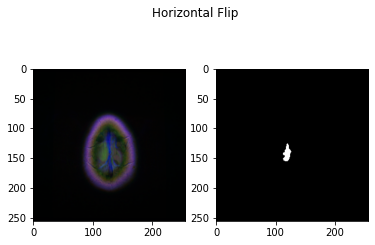

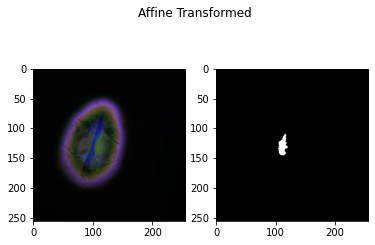

In [13]:
dataset = MRI_Dataset(train_df)
sample = dataset[0]
transform = PairedRandomHorizontalFlip(p=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title="Horizontal Flip")
transform = PairedRandomAffine(
    degrees = (15,15),
    scale_ranges = (1.2, 1.2),
    translate = (0.1,0.1)
)
show_sample(transform(sample), 'Affine Transformed')

In [15]:
train_transforms = transforms.Compose(
    [PairedRandomHorizontalFlip(),
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    PairedToTensor()
    ])

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=PairedToTensor())

train_loader = DataLoader(train_data, batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size,
                         shuffle=False)

# Loading pretrained model

In [16]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


# Use GPU if available

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


# Defining utility functions

Custom metrics

In [18]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

In [19]:
def iou(pred, label):
    intersection = (pred * label).sum()
    union = pred.sum() + label.sum() - intersection
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

Training loop

In [20]:
def train_loop(model, optimizer, criterion, train_loader):
    running_loss = 0
    model.train()
    
    final_dice_coef = 0 

    for i, data in enumerate(train_loader, 0):
        imgs, masks = data

        imgs = imgs.to(device)
        masks = masks.to(device)
        
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

Validation loop

In [21]:
def eval_loop(model, criterion, eval_loader):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        for i, data in enumerate(eval_loader, 0):
            
            imgs, masks = data
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

General training function

In [22]:
def train(model, optimizer, criterion, scheduler, train_loader, valid_loader,
          num_epochs = epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, 
                                   train_loader)
        
        val_metrics = eval_loop(model, criterion, valid_loader)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        #if val_metrics["loss"] <= valid_loss_min:
        #    torch.save(model.state_dict(), "UNET.pt")
        #    valid_loss_min = val_metrics["loss"]
        
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

# Train model

In [23]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
criterion = nn.BCELoss(reduction='mean')
# only one epoch, just to show that we could train the model in the notebook
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader, num_epochs=1)

/tmp/ipykernel_742543/3255609807.py:8: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)


Epoch: 1
Train Loss: 0.03442
Train Dice Coef: 0.35387
Valid Loss: 0.02335
Valid Dice Coef: 0.43048



# Run inference

In [24]:
def plot_pred(model, sample_idx):
    sample_img, sample_mask = valid_data[sample_idx]
    sample_img_tensor = torch.FloatTensor(np.expand_dims(sample_img, 0))
    sample_img_tensor = sample_img_tensor.to(device)

    sample_img = torch.Tensor(sample_img).permute(1,2,0)
    
    model.eval()
    sample_pred = model(sample_img_tensor)
    sample_pred = sample_pred.cpu().detach().numpy()
    
    fig, ax = plt.subplots(1, 3, figsize=(20,10))
    ax[0].title.set_text("Original image")
    ax[0].imshow(sample_img)
    
    ax[1].title.set_text("Ground truth")
    ax[1].imshow(sample_mask[0], cmap="gray")
    
    ax[2].title.set_text("Prediction")
    ax[2].imshow(sample_pred[0][0], cmap="gray")
    
    plt.show()

It is supposed to be bad if we train for a single epoch

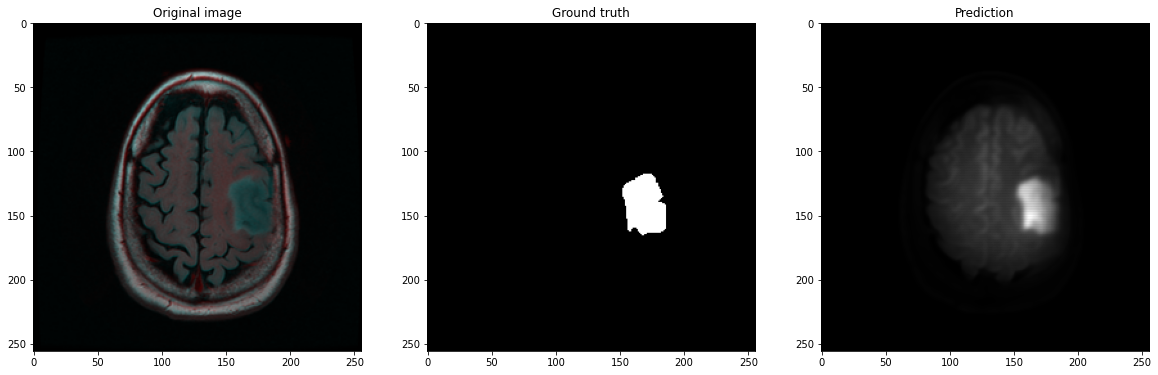

In [31]:
plot_pred(model, 2)

# Loading determined checkpoint

In [26]:
from determined.experimental import client
from determined import pytorch

checkpoint = client.get_experiment(35).top_checkpoint()
path = checkpoint.download("best_checkpoint")

In [27]:
trial = pytorch.load_trial_from_checkpoint_path(path)
loaded_model = trial.model
loaded_model = loaded_model.to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


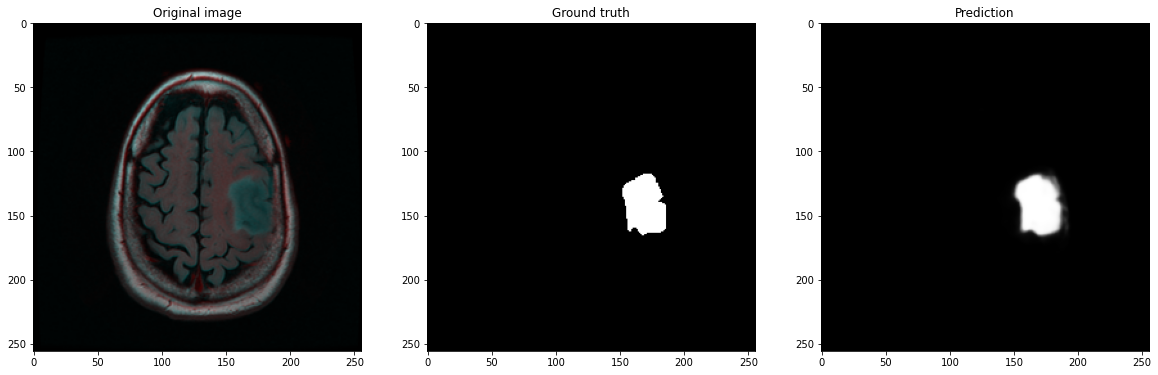

In [32]:
plot_pred(loaded_model, 2)